# Preparación para el TF MDS

## Modelación

Dataset: https://www.yelp.com/dataset/documentation/main

**Requiere ejecución prévia del notebook 02_crear_estructura_dataset_HF** para organizar fotos validas en una estructura de carpetas de datasets de Hugging Face.

Se utiliza la versión [facebook/deit-base-distilled-patch16-224](https://huggingface.co/facebook/deit-base-distilled-patch16-224) del **Transformer DeiT**, ya pré-entrenado con 1 millón de imagenes en 1.000 clases.

In [58]:
from datasets import load_dataset, Image, load_metric

In [59]:
dataset = load_dataset("dataset/hf_toy")

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Using custom data configuration hf_toy-b5cb7a5a7c351e10
Reusing dataset imagefolder (/root/.cache/huggingface/datasets/imagefolder/hf_toy-b5cb7a5a7c351e10/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/3 [00:00<?, ?it/s]

In [60]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})

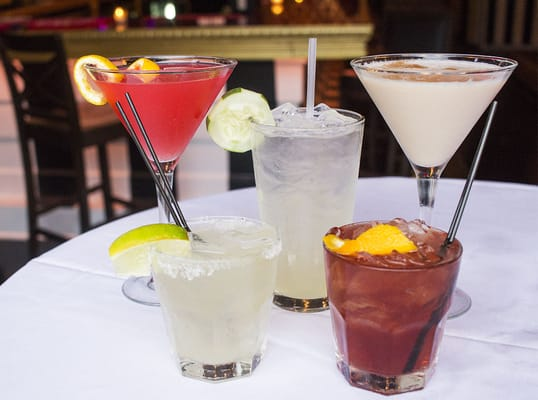

In [61]:
dataset['train'][0]['image']

In [62]:
dataset['train'][0]['label']

0

In [63]:
dataset["train"].features["label"]

ClassLabel(num_classes=5, names=['drink', 'food', 'inside', 'menu', 'outside'], id=None)

## Tuneo del modelo DeiT con el dataset (max_photos=5.000)

In [64]:
from datasets import load_metric

metric = load_metric("accuracy")

In [65]:
dataset["train"].features["label"]

ClassLabel(num_classes=5, names=['drink', 'food', 'inside', 'menu', 'outside'], id=None)

In [66]:
label2id, id2label = dict(), dict()

for i, class_name in enumerate(dataset["train"].features["label"].names):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [67]:
id2label

{'0': 'drink', '1': 'food', '2': 'inside', '3': 'menu', '4': 'outside'}

In [68]:
label2id

{'drink': '0', 'food': '1', 'inside': '2', 'menu': '3', 'outside': '4'}

### Preparar fotos

Transformaciones:
1. Reducir tamaño a 224 x 224
2. Normalizar los canales RGB

In [69]:
model_checkpoint = "facebook/deit-base-distilled-patch16-224"
batch_size = 32

In [70]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/preprocessor_config.json
Feature extractor DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 256
}



DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 256
}

In [71]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [72]:
# split up training into training + validation
train_ds = dataset['train']
val_ds = dataset['test']

In [73]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [74]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=538x400>,
 'label': 0,
 'pixel_values': tensor([[[1.0502, 1.0502, 1.0502,  ..., 1.1700, 1.1700, 1.1700],
          [1.0502, 1.0502, 1.0502,  ..., 1.1872, 1.1872, 1.1872],
          [1.0331, 1.0331, 1.0331,  ..., 1.2043, 1.2043, 1.2043],
          ...,
          [0.9474, 0.9646, 0.9817,  ..., 1.6495, 1.6324, 1.6153],
          [0.9474, 0.9474, 0.9474,  ..., 1.6153, 1.5982, 1.5810],
          [0.9474, 0.9474, 0.9303,  ..., 1.5982, 1.5639, 1.5468]],
 
         [[1.0805, 1.0805, 1.0805,  ..., 1.2906, 1.2906, 1.2906],
          [1.0805, 1.0805, 1.0805,  ..., 1.3081, 1.3081, 1.3081],
          [1.0630, 1.0630, 1.0630,  ..., 1.3256, 1.3256, 1.3256],
          ...,
          [0.4503, 0.4328, 0.3978,  ..., 1.7983, 1.7808, 1.7633],
          [0.5028, 0.4678, 0.3978,  ..., 1.7808, 1.7458, 1.7283],
          [0.5378, 0.4853, 0.3978,  ..., 1.7633, 1.7283, 1.7108]],
 
         [[1.4200, 1.4200, 1.4200,  ..., 1.8905, 1.8905, 1.8905],
  

### Tuneo del modelo
Source: https://colab.research.google.com/drive/1y8Thdk-hbT7vFS0SZDhNsXdDhh0y-JmE#scrollTo=4aNMErFz-GzX

In [75]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--deit-base-distilled-patch16-224/snapshots/a0fc9b37fdb63c112e76104f669208784ecfe4ea/config.json
Model config DeiTConfig {
  "_name_or_path": "facebook/deit-base-distilled-patch16-224",
  "architectures": [
    "DeiTForImageClassificationWithTeacher"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "drink",
    "1": "food",
    "2": "inside",
    "3": "menu",
    "4": "outside"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "drink": "0",
    "food": "1",
    "inside": "2",
    "menu": "3",
    "outside": "4"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.22.0.dev0

In [76]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [77]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [78]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [79]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/ptsilva/deit-base-distilled-patch16-224-finetuned-eurosat into local empty directory.


### Inspeccionar el modelo

In [88]:
trainer.train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [89]:
trainer.eval_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50
})

In [87]:
trainer.tokenizer

DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 256
}

In [83]:
trainer.model

DeiTForImageClassificationWithTeacher(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear

In [84]:
trainer.args

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=4,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None,
label_s

In [80]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 400
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 9


TypeError: forward() got an unexpected keyword argument 'labels'

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
trainer.push_to_hub()